# Ensemble Challenge (18-month Evaluation)

## Timepoint: July 19, 2021. 

## Setting: New York State upon the arrival of the Delta variant, vaccines available

### Load dependencies

In [1]:
import pandas as pd

import pyciemss
import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories
from pyciemss.integration_utils.result_processing import cdc_format

# Process data

In [2]:
location = "New York State"
# BETTER_NAMES = {'Cases': 'Infected',
#                 'Hospitalizations': 'Hospitalized',
#                 'Deaths': 'Dead'}
# ## instantiate, making sure no dates are skipped between start and end (could be found dynamically)
# full_dataset = pd.DataFrame({'date':pd.date_range(start='1/22/2020', end='3/29/2024')})

# ## fill the instantiated dataset
# for i in ['Cases','Hospitalizations','Deaths']:
#     all_data = pd.read_csv(f'https://media.githubusercontent.com/media/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20{i}.csv')
#     subset   = all_data[all_data.location_name == location].groupby("date")["value"].sum().reset_index()
#     subset.date = pd.to_datetime(subset.date)
#     subset['cumsum'] = subset.value.cumsum()
#     full_dataset = full_dataset.merge(subset[['date','cumsum']], how='outer', on='date').rename(columns={'cumsum':BETTER_NAMES[i]})

# full_dataset[(full_dataset.date >= '2021-06-01') & (full_dataset.date < '2021-09-06')].reset_index(drop=True).reset_index(names=['Timestamp']).drop(['date'],axis=1)

## Save full dataset
# full_dataset.to_csv('full_dataset.csv', index=False)
full_dataset = pd.read_csv('full_dataset.csv')

## Define a function to select a subset of the data
def get_data_between(start='2021-06-01',end='2021-09-06'):
    return full_dataset[(full_dataset.date >= start) & (full_dataset.date < end)].reset_index(drop=True).reset_index(names=['Timestamp']).drop(['date'],axis=1)

### Define a function to process output to CDC format

In [3]:
def save_results_cdc_format(result, start_date, location, train_end_point):
    ensemble_data = cdc_format(
        result["ensemble_quantiles"],
        solution_string_mapping = {
            "incident_cases_state": "inc cases",
            "incident_hosp_state": "inc hosp",
            "incident_deaths_state": "inc death",
            "cumulative_cases_state": "cum cases",
            "cumulative_hosp_state": "cum hosp",
            "deceased_state": "cum death",
        },
        forecast_start_date=start_date,
        location=location,
        drop_column_names=[
            "timepoint_id",
            "number_days",
            "output",
        ],
        train_end_point=train_end_point,
    )
    return ensemble_data

### Define a function to plot results

In [4]:
def plot_results_and_data(results, data):
    # Plot the result for cumulative cases, hospitalizations, and deaths
    nice_labels={"deceased_state": "Deaths", "Cumulative_hosp_state": "Cumul Hosp", "Cumulative_cases_state": "Cumul Cases"}
    schema = plots.trajectories(results["data"], 
                                keep=["deceased_state", "Cumulative_hosp_state", "Cumulative_cases_state"], 
                                relabel=nice_labels,
                                points=data.drop(columns=['Timestamp']).reset_index(drop=True)
                               )
    # plots.save_schema(schema, "_schema.json")
    # plots.ipy_display(schema, dpi=150)
    return schema

def plot_all_results(results):
    # Plot the result for all state variables
    schema = plots.trajectories(results["data"], keep=".*_observable_state")
    return schema

# Gather models

In [5]:
# See `Model_Kitchen.ipynb` for model derivation
model1 = "SEIRHD_age_structured_petrinet.json"
model2 = "SEIRHD_vacc_var_petrinet.json"
model3 = "SEIRHD_base_petrinet.json"
# model4 = "SEIRHD_time_varying_transmission_petrinet.json"

### Define solution mappings for each model

In [6]:
def solution_mapping(model_solution: dict) -> dict:
    # solution mapping for model1 and model2 and model3 (they all have the same set of observables)
    mapped_dict = {}
    mapped_dict["Susceptible"] = model_solution["susceptible"]
    mapped_dict["Exposed"] = model_solution["exposed"]
    mapped_dict["Infected"] = model_solution["infected"]
    mapped_dict["Recovered"] = model_solution["recovered"]
    mapped_dict["Hospitalized"] = model_solution["hospitalized"]
    mapped_dict["Deceased"] = model_solution["deceased"]
    mapped_dict["Cumulative_cases"] = model_solution["cumulative_cases"]
    mapped_dict["Cumulative_hosp"] = model_solution["cumulative_hosp"]
    mapped_dict["Incident_deaths"] = model_solution["incident_deaths"]
    mapped_dict["Incident_cases"] = model_solution["incident_cases"]
    mapped_dict["Incident_hosp"] = model_solution["incident_hosp"]
    return mapped_dict

### Set model paths and parameters for sampling

In [7]:
num_iterations = 10
num_samples = 20
start_time = 0.0
logging_step_size = 1.0

single_model_paths = [[model1], [model2], [model3]]
model_paths = [model1, model2, model3]

single_solution_mapping = [lambda x : x]
solution_mappings = [solution_mapping, solution_mapping, solution_mapping]

single_data_mapping = {'Infected': 'Cumulative_cases', 'Hospitalized': 'Cumulative_hosp', 'Dead': 'deceased'}
data_mapping = {'Infected': 'Cumulative_cases', 'Hospitalized': 'Cumulative_hosp', 'Dead': 'Deceased'}

# (1) Forecast 1: 07/19/2021 - 08/16/2021

In [8]:
dataset = get_data_between('2021-06-01', '2021-07-18')
end_time = len(dataset) + 27.0
train_end_point = len(dataset) - 1.0

## (A) Calibrate each model as an ensemble of a single model 

### Model 1

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 46 rows of data. The first column, Timestamp, begins at 0 and ends at 46. The subsequent columns are named: Infected, Hospitalized, Dead


/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/result_processing.py:277: UserWarning: cdc_format only works for time_unit=daystime_unit will default to days and overwrite previous time_unit.
  warnings.warn(
/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/result_processing.py:332: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  q_ensemble_data["forecast_date"] = pd.to_datetime(


,timepoint_id,sample_id,timepoint_unknown,model_0/weight_param,model_0/persistent_beta_param,model_0/persistent_r_EI_param,model_0/persistent_r_IR_y_param,model_0/persistent_r_IR_m_param,model_0/persistent_r_IH_y_param,model_0/persistent_r_IH_m_param,...,exposed_state,infected_state,recovered_state,hospitalized_state,deceased_state,cumulative_cases_state,cumulative_hosp_state,incident_cases_state,incident_hosp_state,incident_deaths_state
0,0,0,0.0,1.0,0.000537,0.173519,0.445719,0.152712,0.024774,0.055804,...,4000.000000,3925.956543,2102000.0,700.000000,53123.000000,2102869.0,136862.000000,465.000000,113.000000,25.000000
1,1,0,1.0,1.0,0.000537,0.173519,0.445719,0.152712,0.024774,0.055804,...,3397.614746,3613.773926,2102909.0,735.285339,53130.984375,2103510.0,137033.421875,570.444092,149.375412,14.274704
2,2,0,2.0,1.0,0.000537,0.173519,0.445719,0.152712,0.024774,0.055804,...,2888.281738,3312.873291,2103721.5,759.822083,53139.468750,2104051.0,137193.421875,549.245544,155.572968,10.646544
3,3,0,3.0,1.0,0.000537,0.173519,0.445719,0.152712,0.024774,0.055804,...,2457.302979,3022.718750,2104451.5,773.647827,53148.343750,2104516.5,137341.765625,490.702942,150.274368,9.532343
4,4,0,4.0,1.0,0.000537,0.173519,0.445719,0.152712,0.024774,0.055804,...,2092.317871,2744.674805,2105111.0,777.312561,53157.414062,2104910.5,137477.765625,426.208405,140.624069,9.249744


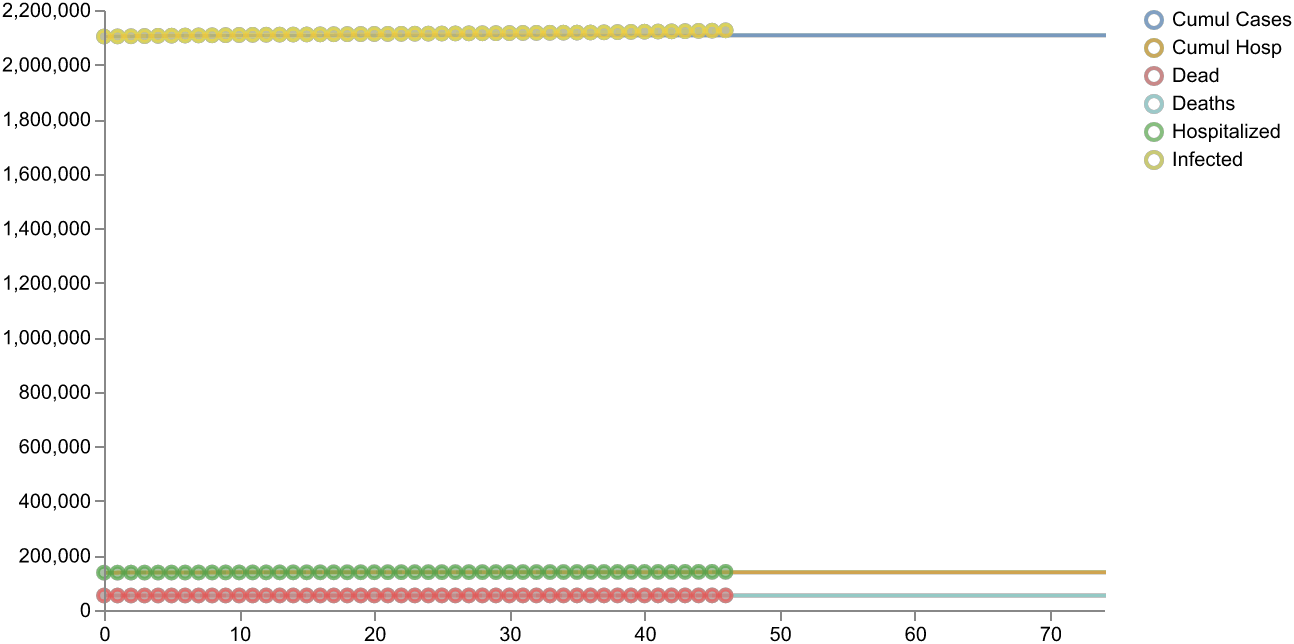

In [9]:
## Calibrate the model to data
calibrated_results = pyciemss.ensemble_calibrate(single_model_paths[0], single_solution_mapping, dataset, 
                                                 data_mapping=single_data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
# print(parameter_estimates())

## Sample the calibrated model
calibrated_ensemble_result = pyciemss.ensemble_sample(single_model_paths[0], single_solution_mapping, 
                                                      end_time, logging_step_size, num_samples, 
                                                      start_time=start_time, inferred_parameters=parameter_estimates)

# ## Save results
save_results_cdc_format(calibrated_ensemble_result, "2021-07-19", location, train_end_point).to_csv('ensemble1_forecast_0719.csv', index=False)

## Display results
display(calibrated_ensemble_result['data'].head())
schema = plot_results_and_data(calibrated_ensemble_result, dataset)
# schema = plot_all_results(calibrated_ensemble_result)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

In [24]:
df = calibrated_ensemble_result["data"]
df['new_A'] = df["cumulative_hosp_state"] + df["incident_hosp_state"]
df[0:5]

,timepoint_id,sample_id,timepoint_unknown,model_0/weight_param,model_0/persistent_beta_param,model_0/persistent_r_EI_param,model_0/persistent_r_IR_y_param,model_0/persistent_r_IR_m_param,model_0/persistent_r_IH_y_param,model_0/persistent_r_IH_m_param,...,recovered_state,hospitalized_state,deceased_state,cumulative_cases_state,cumulative_hosp_state,incident_cases_state,incident_hosp_state,incident_deaths_state,new_A,A_diff
0,0,0,0.0,1.0,0.000537,0.173519,0.445719,0.152712,0.024774,0.055804,...,2102000.0,700.000000,53123.000000,2102869.0,136862.000000,465.000000,113.000000,25.000000,136975.000000,NaN
1,1,0,1.0,1.0,0.000537,0.173519,0.445719,0.152712,0.024774,0.055804,...,2102909.0,735.285339,53130.984375,2103510.0,137033.421875,570.444092,149.375412,14.274704,137182.797287,171.421875
2,2,0,2.0,1.0,0.000537,0.173519,0.445719,0.152712,0.024774,0.055804,...,2103721.5,759.822083,53139.468750,2104051.0,137193.421875,549.245544,155.572968,10.646544,137348.994843,160.000000
3,3,0,3.0,1.0,0.000537,0.173519,0.445719,0.152712,0.024774,0.055804,...,2104451.5,773.647827,53148.343750,2104516.5,137341.765625,490.702942,150.274368,9.532343,137492.039993,148.343750
4,4,0,4.0,1.0,0.000537,0.173519,0.445719,0.152712,0.024774,0.055804,...,2105111.0,777.312561,53157.414062,2104910.5,137477.765625,426.208405,140.624069,9.249744,137618.389694,136.000000


In [19]:
df

,timepoint_id,sample_id,timepoint_unknown,model_0/weight_param,model_0/persistent_beta_param,model_0/persistent_r_EI_param,model_0/persistent_r_IR_y_param,model_0/persistent_r_IR_m_param,model_0/persistent_r_IH_y_param,model_0/persistent_r_IH_m_param,...,recovered_state,hospitalized_state,deceased_state,cumulative_cases_state,cumulative_hosp_state,incident_cases_state,incident_hosp_state,incident_deaths_state,new_A,A_diff
0,0,0,0.0,1.0,0.000537,0.173519,0.445719,0.152712,0.024774,0.055804,...,2102000.00,700.000000,53123.000000,2102869.00,136862.000000,465.000000,113.000000,25.000000,136975.000000,NaN
1,1,0,1.0,1.0,0.000537,0.173519,0.445719,0.152712,0.024774,0.055804,...,2102909.00,735.285339,53130.984375,2103510.00,137033.421875,570.444092,149.375412,14.274704,137182.797287,171.421875
2,2,0,2.0,1.0,0.000537,0.173519,0.445719,0.152712,0.024774,0.055804,...,2103721.50,759.822083,53139.468750,2104051.00,137193.421875,549.245544,155.572968,10.646544,137348.994843,160.000000
3,3,0,3.0,1.0,0.000537,0.173519,0.445719,0.152712,0.024774,0.055804,...,2104451.50,773.647827,53148.343750,2104516.50,137341.765625,490.702942,150.274368,9.532343,137492.039993,148.343750
4,4,0,4.0,1.0,0.000537,0.173519,0.445719,0.152712,0.024774,0.055804,...,2105111.00,777.312561,53157.414062,2104910.50,137477.765625,426.208405,140.624069,9.249744,137618.389694,136.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,70,19,70.0,1.0,0.000513,0.174854,0.448875,0.154186,0.025272,0.055359,...,2110815.50,0.630286,53294.984375,2107210.75,138560.218750,0.018702,0.014105,0.010094,138560.232855,0.015625
1496,71,19,71.0,1.0,0.000513,0.174854,0.448875,0.154186,0.025272,0.055359,...,2110814.25,0.550671,53295.039062,2107210.75,138560.234375,0.016110,0.012157,0.008844,138560.246532,0.015625
1497,72,19,72.0,1.0,0.000513,0.174854,0.448875,0.154186,0.025272,0.055359,...,2110814.00,0.481012,53295.000000,2107210.75,138560.250000,0.013878,0.010479,0.007747,138560.260479,0.015625
1498,73,19,73.0,1.0,0.000513,0.174854,0.448875,0.154186,0.025272,0.055359,...,2110814.00,0.420080,53294.992188,2107210.75,138560.250000,0.011956,0.009031,0.006784,138560.259031,0.000000


In [28]:
df = calibrated_ensemble_result["data"]
df['C_diff'] = df['cumulative_cases_state'].diff()
df['H_diff'] = df['cumulative_hosp_state'].diff()
df['D_diff'] = df['deceased_state'].diff()

print(df[["D_diff", "incident_deaths_state"]]) #, "H_diff", "incident_hosp_state", "D_diff", "incident_deaths_state"]])

        D_diff  incident_deaths_state
0          NaN              25.000000
1     7.984375              14.274704
2     8.484375              10.646544
3     8.875000               9.532343
4     9.070312               9.249744
...        ...                    ...
1495  0.007812               0.010094
1496  0.054688               0.008844
1497 -0.039062               0.007747
1498 -0.007812               0.006784
1499  0.019531               0.005940

[1500 rows x 2 columns]


In [16]:
df = calibrated_ensemble_result["data"]

### Model 2

In [ ]:
# ## Calibrate the model to data
# calibrated_results = pyciemss.ensemble_calibrate(single_model_paths[1], single_solution_mapping, dataset, 
#                                                  data_mapping=single_data_mapping, num_iterations=num_iterations)
# parameter_estimates = calibrated_results["inferred_parameters"]
# # print(parameter_estimates())

# ## Sample the calibrated model
# calibrated_ensemble_result = pyciemss.ensemble_sample(single_model_paths[1], single_solution_mapping, 
#                                                       end_time, logging_step_size, num_samples, 
#                                                       start_time=start_time, inferred_parameters=parameter_estimates)


## Save results
save_results_cdc_format(calibrated_ensemble_result, "2021-07-19", location, train_end_point).to_csv('ensemble1_forecast_0719.csv', index=False)

## Display results
# display(calibrated_ensemble_result['data'].head())
schema = plot_results_and_data(calibrated_ensemble_result, dataset)
# schema = plot_all_results(calibrated_ensemble_result)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

### Model 3

In [ ]:
## Calibrate the model to data
calibrated_results = pyciemss.ensemble_calibrate(single_model_paths[2], single_solution_mapping, dataset, 
                                                 data_mapping=single_data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
# print(parameter_estimates())

## Sample the calibrated model
calibrated_ensemble_result = pyciemss.ensemble_sample(single_model_paths[2], single_solution_mapping, 
                                                      end_time, logging_step_size, num_samples, 
                                                      start_time=start_time, inferred_parameters=parameter_estimates)

## Save results
# save_results_cdc_format(calibrated_ensemble_result, "2021-07-19", location).to_csv('ensemble1_forecast_0719.csv', index=False)

## Display results
# display(calibrated_ensemble_result['data'].head())
schema = plot_results_and_data(calibrated_ensemble_result, dataset)
# schema = plot_all_results(calibrated_ensemble_result)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## (B) Calibrate an ensemble of multiple models

In [ ]:
## Calibrate the model to data
calibrated_results = pyciemss.ensemble_calibrate(model_paths, solution_mappings, dataset, 
                                                 data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
# print(parameter_estimates())

## Sample the calibrated model
ensemble_result = pyciemss.ensemble_sample(model_paths, solution_mappings, end_time, 
                                           logging_step_size, num_samples, start_time=start_time)

## Save results
save_results_cdc_format(calibrated_ensemble_result, "2021-07-19", location).to_csv('ensemble3_forecast_0719.csv', index=False)

## Display results
# display(ensemble_result['data'].head())
schema = plot_results_and_data(calibrated_ensemble_result, dataset)
# schema = plot_all_results(calibrated_ensemble_result)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

# (2) Forecast 2: 07/26/2021 - 08/23/2021

In [ ]:
dataset = get_data_between('2021-06-01', '2021-07-25')
end_time = len(dataset) + 29.0

## (A) Calibrate an ensemble of a single model

In [ ]:
## Calibrate the model to data
calibrated_results = pyciemss.ensemble_calibrate(single_model_paths[1], single_solution_mapping, dataset, 
                                                 data_mapping=single_data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
# print(parameter_estimates())

## Sample the calibrated model
calibrated_ensemble_result = pyciemss.ensemble_sample(single_model_paths[1], single_solution_mapping, 
                                                      end_time, logging_step_size, num_samples, 
                                                      start_time=start_time, inferred_parameters=parameter_estimates)

## Save results
save_results_cdc_format(calibrated_ensemble_result, "2021-07-26", location).to_csv('ensemble1_forecast_0726.csv', index=False)

## Display results
# display(calibrated_ensemble_result['data'].head())
schema = plot_results_and_data(calibrated_ensemble_result, dataset)
# schema = plot_all_results(calibrated_ensemble_result)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## (B) Calibrate an ensemble of multiple models

In [ ]:
## Calibrate the model to data
calibrated_results = pyciemss.ensemble_calibrate(model_paths, solution_mappings, dataset, 
                                                 data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
# print(parameter_estimates())

## Sample the calibrated model
ensemble_result = pyciemss.ensemble_sample(model_paths, solution_mappings, end_time, 
                                           logging_step_size, num_samples, start_time=start_time)

## Save results
save_results_cdc_format(calibrated_ensemble_result, "2021-07-26", location).to_csv('ensemble3_forecast_0726.csv', index=False)

## Display results
# display(ensemble_result['data'].head())
schema = plot_results_and_data(calibrated_ensemble_result, dataset)
# schema = plot_all_results(calibrated_ensemble_result)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

# (3) Forecast 3: 08/02/2021 - 08/30/2021

In [ ]:
dataset = get_data_between('2021-06-01', '2021-08-01')
end_time = len(dataset) + 29.0

## (A) Calibrate an ensemble of a single model

In [ ]:
## Calibrate the model to data
calibrated_results = pyciemss.ensemble_calibrate(single_model_paths[1], single_solution_mapping, dataset, 
                                                 data_mapping=single_data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
# print(parameter_estimates())

## Sample the calibrated model
calibrated_ensemble_result = pyciemss.ensemble_sample(single_model_paths[1], single_solution_mapping, 
                                                      end_time, logging_step_size, num_samples, 
                                                      start_time=start_time, inferred_parameters=parameter_estimates)

## Save results
save_results_cdc_format(calibrated_ensemble_result, "2021-08-02", location).to_csv('ensemble1_forecast_0802.csv', index=False)

## Display results
# display(calibrated_ensemble_result['data'].head())
schema = plot_results_and_data(calibrated_ensemble_result, dataset)
# schema = plot_all_results(calibrated_ensemble_result)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## (B) Calibrate an ensemble of multiple models

In [ ]:
## Calibrate the model to data
calibrated_results = pyciemss.ensemble_calibrate(model_paths, solution_mappings, dataset, 
                                                 data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
# print(parameter_estimates())

## Sample the calibrated model
ensemble_result = pyciemss.ensemble_sample(model_paths, solution_mappings, end_time, 
                                           logging_step_size, num_samples, start_time=start_time)

## Save results
save_results_cdc_format(calibrated_ensemble_result, "2021-08-02", location).to_csv('ensemble3_forecast_0802.csv', index=False)

## Display results
# display(ensemble_result['data'].head())
schema = plot_results_and_data(calibrated_ensemble_result, dataset)
# schema = plot_all_results(calibrated_ensemble_result)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

# (4) Forecast 4: 08/09/2021 - 09/06/2021

In [ ]:
dataset = get_data_between('2021-06-01', '2021-08-08')
end_time = len(dataset) + 29.0

## (A) Calibrate an ensemble of a single model

In [ ]:
## Calibrate the model to data
calibrated_results = pyciemss.ensemble_calibrate(single_model_paths[1], single_solution_mapping, dataset, 
                                                 data_mapping=single_data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
# print(parameter_estimates())

## Sample the calibrated model
calibrated_ensemble_result = pyciemss.ensemble_sample(single_model_paths[1], single_solution_mapping, 
                                                      end_time, logging_step_size, num_samples, 
                                                      start_time=start_time, inferred_parameters=parameter_estimates)

## Save results
save_results_cdc_format(calibrated_ensemble_result, "2021-08-09", location).to_csv('ensemble1_forecast_0809.csv', index=False)

## Display results
# display(calibrated_ensemble_result['data'].head())
schema = plot_results_and_data(calibrated_ensemble_result, dataset)
# schema = plot_all_results(calibrated_ensemble_result)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## (B) Calibrate an ensemble of multiple models

In [ ]:
## Calibrate the model to data
calibrated_results = pyciemss.ensemble_calibrate(model_paths, solution_mappings, dataset, 
                                                 data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
# print(parameter_estimates())

## Sample the calibrated model
ensemble_result = pyciemss.ensemble_sample(model_paths, solution_mappings, end_time, 
                                           logging_step_size, num_samples, start_time=start_time)

## Save results
save_results_cdc_format(calibrated_ensemble_result, "2021-08-09", location).to_csv('ensemble3_forecast_0809.csv', index=False)

## Display results
# display(ensemble_result['data'].head())
schema = plot_results_and_data(calibrated_ensemble_result, dataset)
# schema = plot_all_results(calibrated_ensemble_result)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)